# Extracting Prosodic Features and Visualizing Features

**Overview**

This notebook has 3 main parts:

1. Loading the dataset (still to be determined)
2. Extracting features
3. Training neural network or other machine learning models
4. Testing and performance analysis


In [ ]:

import librosa
import librosa.display
import IPython.display as ipd

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import soundfile as sf

import scipy.signal as signal

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Load Dataset

In [ ]:
#  load dataset

'''
Example audio paths from weekly assignment 6 used for testing
'''

data = pd.read_csv("N_1000_filtered_train_data.csv")

data = data.dropna()
data.drop(columns=['potential_question'], inplace=True)
data.drop(columns=['potential_statement'], inplace=True)

data = data[data['label'] != 'unknown']

print("Total rows after filtering: ", data.shape[0])

yn = data[data['label'] == 'yn']
print("Number of clips labeled 'yn': ", yn.shape[0])

wh = data[data['label'] == 'wh']
print("Number of clips labeled 'wh': ", wh.shape[0])

imp = data[data['label'] == 'imp']
print("Number of clips labeled 'imp': ", imp.shape[0])

nq = data[data['label'] == 'nq']
print("Number of clips labeled 'nq': ", nq.shape[0])

filtered_data = pd.concat([yn, wh, imp, nq], ignore_index=True)

filtered_data = data
print(filtered_data)

Total rows after filtering:  985
Number of clips labeled 'yn':  95
Number of clips labeled 'wh':  100
Number of clips labeled 'imp':  236
Number of clips labeled 'nq':  554
     index                                               text  \
0    10500              austrian five two hotel juliett praha   
1    10425                  austrian seven two nine thank you   
2      882                            roger standby for climb   
3    10309  csa three charlie tango runway three one clear...   
4    11616  sky travel one zero one zero confirm ready for...   
..     ...                                                ...   
995   2852         lufthansa seven five four please say again   
996   7195  direct to polom and when ready direct descend ...   
997   5284  lot three nine two praha radar contact stand b...   
998    464  good evening air malta five three nine radar r...   
999   2768  say again air berlin four zero seven berlin fo...   

                      audio_path  word_count l

# Extract Features


In [ ]:
# Example function to extract features

def extract_audio_features(audio_path, sr=None):

    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # low-pass filter
    cutoff_freq = 512  # Cutoff frequency in Hz
    nyquist = sr / 2   
    normal_cutoff = cutoff_freq / nyquist  

    
    b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)

    y = signal.filtfilt(b, a, y)

    # Extract pitch (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                fmin=librosa.note_to_hz('C2'),
                                                fmax=librosa.note_to_hz('C7'))

    # get pitch statistics
    f0_valid = f0[~np.isnan(f0)]
    end_window = min(len(f0_valid), int(0.5 * sr))  # Last 0.5 seconds
    f0_end = f0_valid[-end_window:] if len(f0_valid) > 0 else []

    # get energy contour
    energy = librosa.feature.rms(y=y)[0]

    # get speaking rate proxy using zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    # get MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    features = {
        'f0_mean': np.mean(f0_valid) if len(f0_valid) > 0 else 0,
        'f0_std': np.std(f0_valid) if len(f0_valid) > 0 else 0,
        'f0_end_slope': np.polyfit(np.arange(len(f0_end)), f0_end, 1)[0] if len(f0_end) > 0 else 0,
        'energy_mean': np.mean(energy),
        'energy_std': np.std(energy),
        'zcr_mean': np.mean(zcr),
        'mfcc_means': np.mean(mfccs, axis=1).tolist(),
        'filepath' : audio_path
    }

    return features

In [ ]:
audio_paths = filtered_data['audio_path'].tolist()

features = []

for audio_path in audio_paths:
  features.append(extract_audio_features(audio_path=audio_path))


features_df = pd.DataFrame(features)
print(features_df.head())

In [ ]:
# Combine extracted features with labeled audio clips
features_df.rename(columns={'filepath': 'audio_path'}, inplace=True)


merged_df = pd.merge(filtered_data, features_df, on='audio_path', how='inner')
#print(merged_df.head())

merged_df.to_csv("N_1000_filtered_train_data_with_features.csv", index=False)

   index                                               text  \
0  10500              austrian five two hotel juliett praha   
1  10425                  austrian seven two nine thank you   
2    882                            roger standby for climb   
3  10309  csa three charlie tango runway three one clear...   
4  11616  sky travel one zero one zero confirm ready for...   

                    audio_path  word_count label     f0_mean     f0_std  \
0  audio_files/audio_10500.wav           6   imp  357.180036  19.516794   
1  audio_files/audio_10425.wav           6    nq  545.996867  55.690541   
2    audio_files/audio_882.wav           4    nq    0.000000   0.000000   
3  audio_files/audio_10309.wav          17    nq  611.583890  58.230917   
4  audio_files/audio_11616.wav          19    yn  635.726079  75.972980   

   f0_end_slope  energy_mean  energy_std  zcr_mean  \
0     -0.208062     0.011717    0.004587  0.065323   
1     -6.876172     0.006917    0.004128  0.082935   
2      0

In [88]:
features_df = pd.read_csv("N_1000_filtered_train_data_with_features.csv")
features_df2 = features_df.drop(columns=['mfcc_means', 'audio_path', 'text', 'word_count', 'label', 'index'])  # Drop the file path column for PCA
features_df2 = features_df2[features_df2['f0_mean'] != 0] # Filter out rows where f0_mean is zero

In [89]:
print(features_df2)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df2)  # Standardize before PCA
print(features_scaled)


        f0_mean      f0_std  f0_end_slope  energy_mean  energy_std  zcr_mean
0    357.180036   19.516794     -0.208062     0.011717    0.004587  0.065323
1    545.996867   55.690541     -6.876172     0.006917    0.004128  0.082935
3    611.583890   58.230917     -0.445379     0.027040    0.010321  0.073520
4    635.726079   75.972980     -0.058992     0.024719    0.021063  0.083496
6    562.866153  342.227537     18.420045     0.007035    0.002572  0.095703
..          ...         ...           ...          ...         ...       ...
980  476.963584   65.127156      4.684646     0.004368    0.001671  0.101982
981  498.346940  317.286364    -15.627854     0.014438    0.006959  0.089106
982  311.336486   47.281115     -1.764788     0.034009    0.019886  0.059465
983  309.713658   31.880004     -0.208367     0.023050    0.010541  0.074809
984  355.197699   53.488714     -1.155800     0.015681    0.011150  0.067260

[904 rows x 6 columns]
[[-0.75421548 -0.71955974  0.0188944  -0.3231242  -0

In [90]:
pca = PCA(n_components=2)  # Reduce to 2D
features_pca = pca.fit_transform(features_scaled)

km = KMeans(n_clusters=4, random_state=23)
labels = km.fit_predict(features_pca)


/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_36044/1180682283.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_pca[:, 0], features_pca[:, 1], cmap='viridis', alpha=0.7)


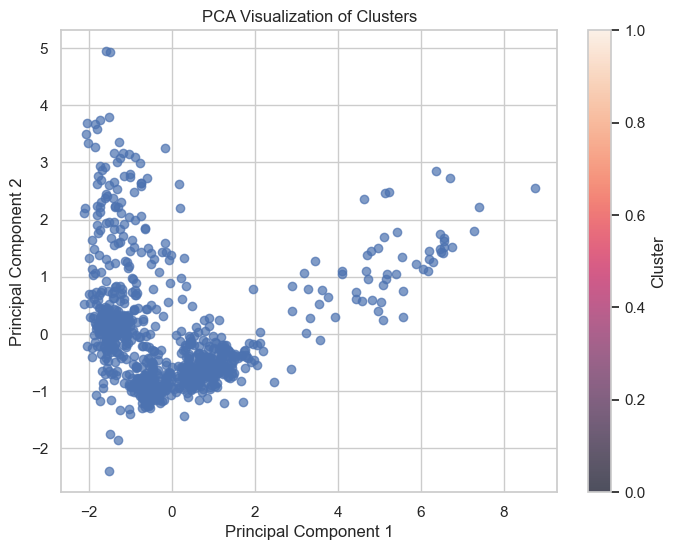

In [91]:
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()


/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_36044/3433093902.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_tsne[:, 0], features_tsne[:, 1], cmap='viridis', alpha=0.7)


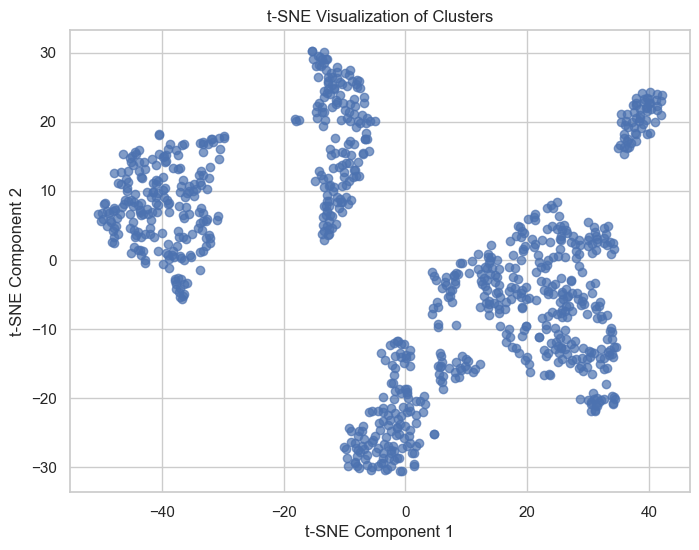

In [93]:
tsne = TSNE(n_components=2, random_state=43)
features_tsne = tsne.fit_transform(features_scaled)

labels = km.fit_predict(features_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.show()

# Visualize

Fundamental Frequency (f0) estimation

Transcription: sorry say again


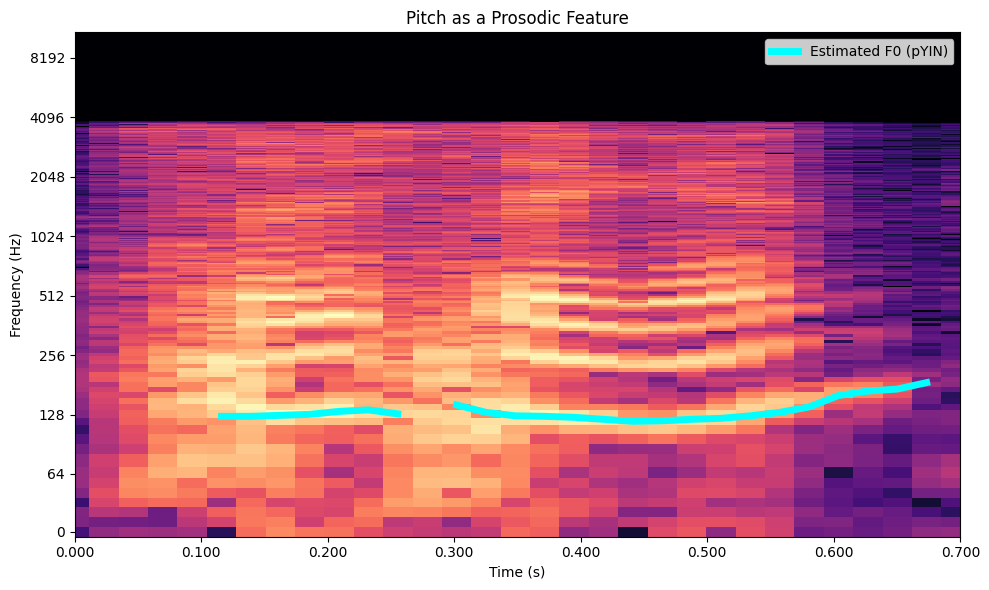

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy import signal

# Load dataset
data = pd.read_csv("N_1000_filtered_train_data_with_features.csv")

# Select an example
index = 2305 # I like this one because it asks "sorry, say again?" with an upwards intonation
row = data[data['index'] == index]

# Get audio path and transcription
audio_path = row['audio_path'].values[0]
text = row['text'].values[0]
print("Transcription:", text)

# Load audio
y, sr = librosa.load(audio_path)

# Apply a low-pass Butterworth filter (optional)
apply_filter = False
if apply_filter:
    cutoff_freq = 512  # Hz
    nyquist = sr / 2
    normal_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(4, normal_cutoff, btype='low')
    y = signal.filtfilt(b, a, y)

# Estimate pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    y,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7')
)


times = librosa.times_like(f0, sr=sr)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, ax=ax, cmap='magma')
#fig.colorbar(img, ax=ax, format="%+2.0f dB", label='Amplitude (dB)')

# Overlay f0 track
ax.plot(times, f0, label='Estimated F0 (pYIN)', color='cyan', linewidth=5, )
ax.set(title='Pitch as a Prosodic Feature', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.legend(loc='upper right')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlim(0, 0.7)
plt.tight_layout()
plt.show()

# play the audio
ipd.Audio(y, rate=sr)


/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_33944/1372305429.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette=colors)
/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_33944/1372305429.py:14: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=labels, y=counts, palette=colors)


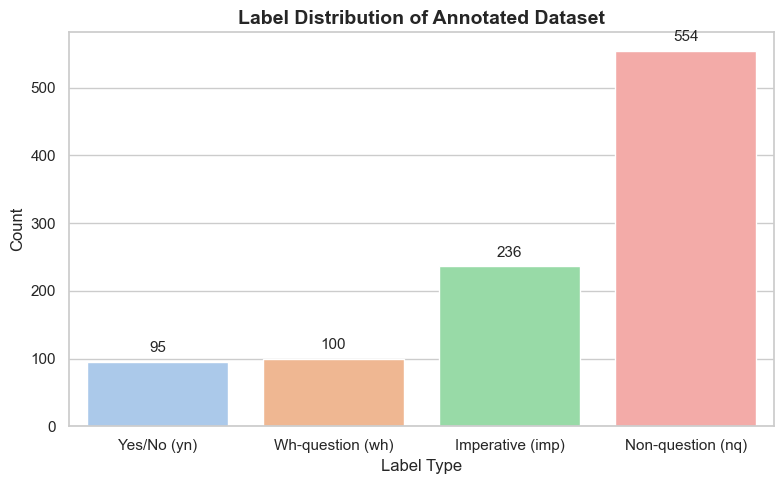

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels = ['Yes/No (yn)', 'Wh-question (wh)', 'Imperative (imp)', 'Non-question (nq)']
counts = [95, 100, 236, 554]

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Barplot
colors = sns.color_palette("pastel")  # Soft colors for a clean poster aesthetic
sns.barplot(x=labels, y=counts, palette=colors)

# Titles and labels
plt.title("Label Distribution of Annotated Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Label Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add value labels above bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=11)

# Adjust layout
plt.tight_layout()
plt.show()


/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_33944/1279131427.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=counts, palette=colors)
/var/folders/58/9sdvxc2d6m750h2y43br5xbr0000gn/T/ipykernel_33944/1279131427.py:14: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(y=labels, x=counts, palette=colors)


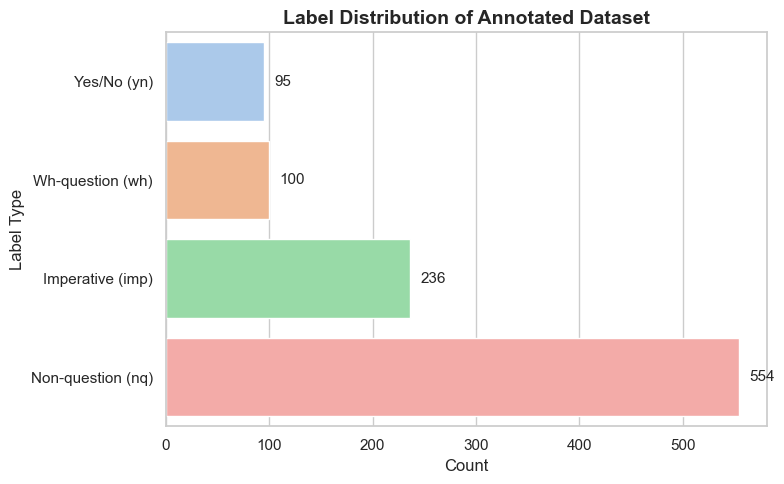

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels = ['Yes/No (yn)', 'Wh-question (wh)', 'Imperative (imp)', 'Non-question (nq)']
counts = [95, 100, 236, 554]

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Horizontal barplot
colors = sns.color_palette("pastel")
sns.barplot(y=labels, x=counts, palette=colors)

# Titles and labels
plt.title("Label Distribution of Annotated Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Count", fontsize=12)
plt.ylabel("Label Type", fontsize=12)

# Add value labels next to bars
for i, count in enumerate(counts):
    plt.text(count + 10, i, str(count), va='center', fontsize=11)

plt.tight_layout()
plt.show()


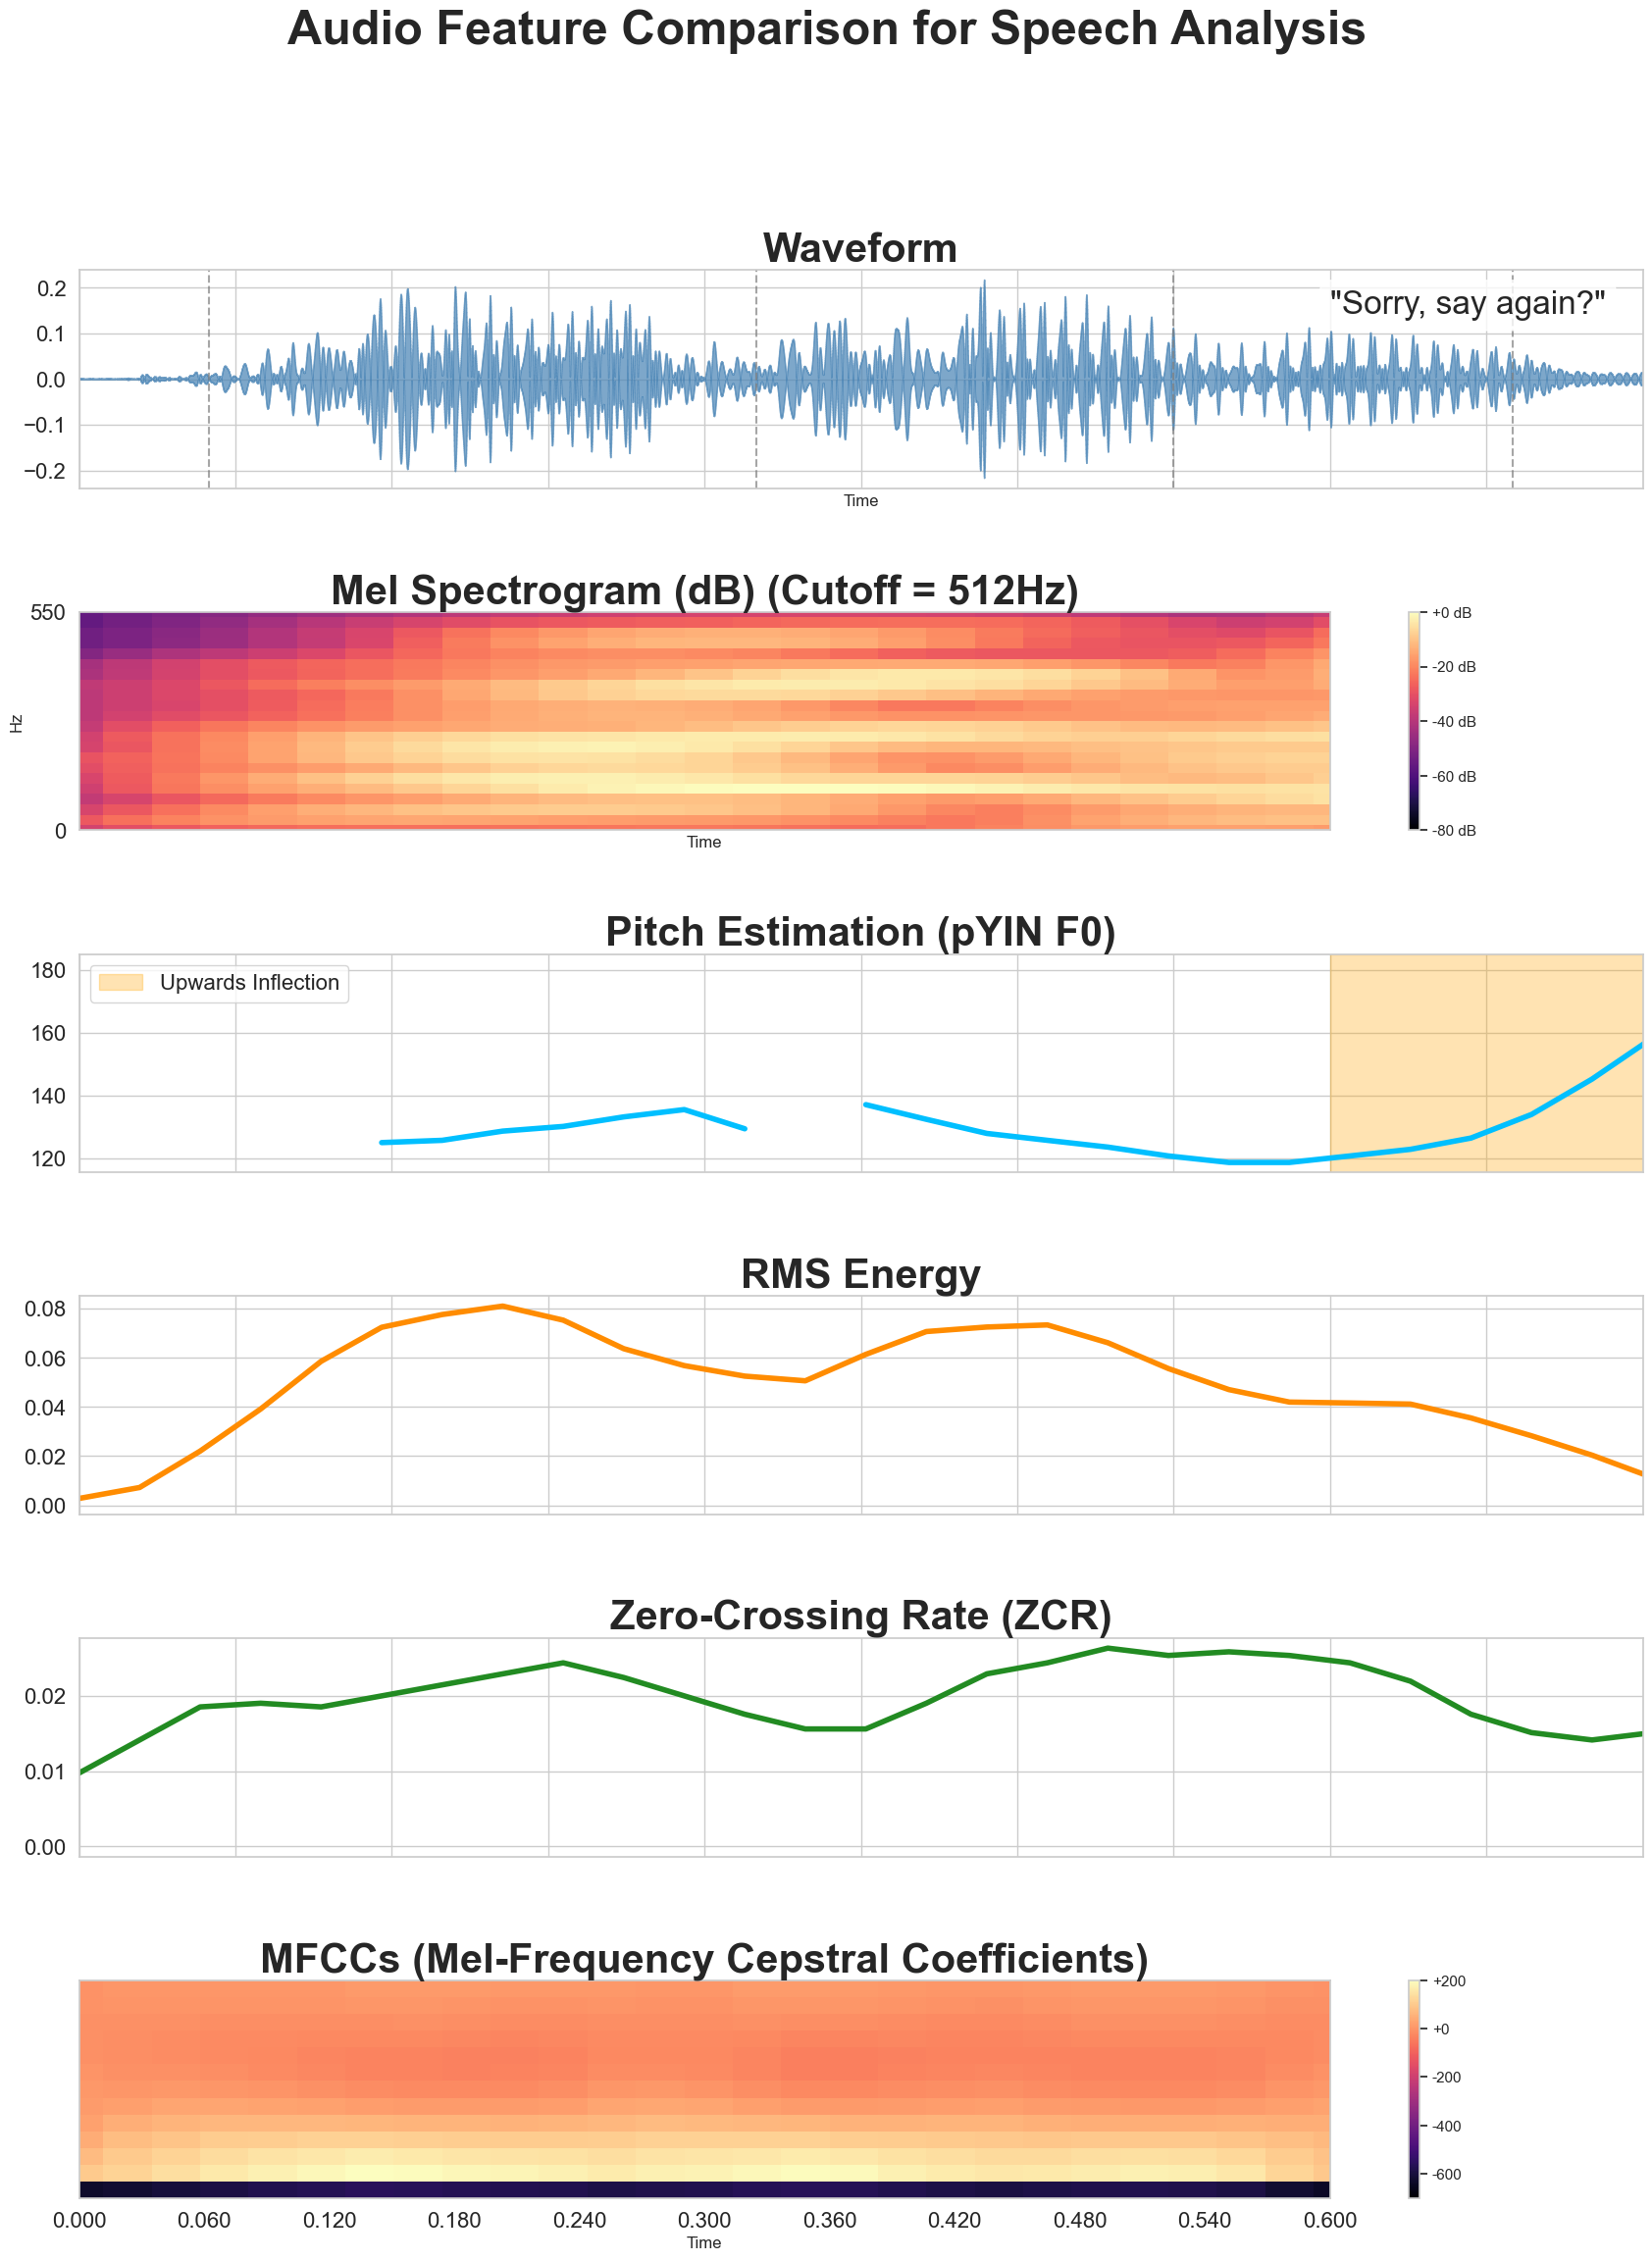

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 

# Load audio
# y, sr = librosa.load("your_audio_file.wav", duration=5)



title_fontsize = 30


f0, _, _ = librosa.pyin(
    y, 
    fmin=librosa.note_to_hz('C2'), 
    fmax=librosa.note_to_hz('C7')
)

# Apply a low-pass  filter
apply_filter = True
if apply_filter:
    cutoff_freq = 512  # Hz
    nyquist = sr / 2
    normal_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(4, normal_cutoff, btype='low')
    y = signal.filtfilt(b, a, y)

energy = librosa.feature.rms(y=y)[0]
zcr = librosa.feature.zero_crossing_rate(y)[0]
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# spectrogram
n_fft = 4096
hop_length = 256
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)


frames = np.arange(len(energy))
t_feature = librosa.frames_to_time(frames, sr=sr)
t_f0 = librosa.times_like(f0, sr=sr)


fig, axs = plt.subplots(6, 1, figsize=(18, 24), sharex=True)
fig.suptitle("Audio Feature Comparison for Speech Analysis", fontsize=35, fontweight='bold')

# waveform
librosa.display.waveshow(y, sr=sr, ax=axs[0], alpha=0.7, color='steelblue')
axs[0].set_title("Waveform", fontsize=title_fontsize, fontweight='bold')
axs[0].tick_params(labelsize=16)


axs[0].text(0.8, 0.8, '"Sorry, say again?"', transform=axs[0].transAxes,
            fontsize=24, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

# vertical word boundary markers (approximate)
word_boundaries = [0.05, 0.26, 0.42, 0.55]
for tb in word_boundaries:
    axs[0].axvline(tb, color='gray', linestyle='--', alpha=0.7)

# spectogram
img_spec = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma', ax=axs[1])
axs[1].set_title("Mel Spectrogram (dB) (Cutoff = 512Hz)", fontsize=title_fontsize, fontweight='bold')
axs[1].tick_params(labelsize=16)
axs[1].set_ylim(0, 550)
fig.colorbar(img_spec, ax=axs[1], format="%+2.0f dB")

# pitch
axs[2].plot(t_f0, f0, color='deepskyblue', linewidth=4)
axs[2].set_title("Pitch Estimation (pYIN F0)", fontsize=title_fontsize, fontweight='bold')
axs[2].tick_params(labelsize=16)

# Highlight pitch inflection region at the end
inflection_start = 0.48
inflection_end = 0.6
axs[2].axvspan(inflection_start, inflection_end, color='orange', alpha=0.3, label='Upwards Inflection')
axs[2].legend(fontsize=16)

# energy
axs[3].plot(t_feature, energy, color='darkorange', linewidth=4)
axs[3].set_title("RMS Energy", fontsize=title_fontsize, fontweight='bold')
axs[3].tick_params(labelsize=16)

# zcr
axs[4].plot(t_feature, zcr, color='forestgreen', linewidth=4)
axs[4].set_title("Zero-Crossing Rate (ZCR)", fontsize=title_fontsize, fontweight='bold')
axs[4].tick_params(labelsize=16)

# mfccs
img_mfcc = librosa.display.specshow(mfccs, x_axis='time', sr=sr, ax=axs[5], cmap='magma')
axs[5].set_title("MFCCs (Mel-Frequency Cepstral Coefficients)", fontsize=title_fontsize, fontweight='bold')
axs[5].tick_params(labelsize=16)
fig.colorbar(img_mfcc, ax=axs[5], format="%+2.0f")

# set x-axis limits for all subplots
for ax in axs:
    ax.set_xlim(0, 0.6)

# Final layout
plt.tight_layout(pad=4, rect=[0, 0, 1, 0.96])
plt.show()
